# Long-only summary

This notebook summarises major performance statistics for long-only futures contracts provided by Quandl.

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

from adagio.stats.performance import Performance, PerfStats
from adagio.utils import keys
from adagio.utils.const import FuturesInfo
from adagio.utils.mongo import get_library

First, connect to the arctic library named "longonly" to retrieve long-only data.

In [2]:
library = get_library(keys.backtest)

Let's see major statistics for each contract. This is done by looping over all futures contracts saved in the db.

In [3]:
results = []
for fut in FuturesInfo:
    key, futures_info = fut.name, fut.value
    
    # only retrieve 1st contract performance
    symbol = library.list_symbols(lo_ticker=key, nth_contract=1)
    assert len(symbol) == 1
    
    item = library.read(symbol[0])
    data = item.data
    lo_object = data[0][0]
    
    longonly_returns = data.get_final_net_returns()
    stats = longonly_returns.add(1).cumprod().pipe(Performance).summary()
    volume_2017 = lo_object.get_generic_volume()[slice('20170101', '20171231')].median()
    
    results.append([
        futures_info.full_name,
        futures_info.asset_class,
        longonly_returns.index[0].strftime("%Y%m%d"),
        stats.loc[PerfStats.ANN_RETURN.value, longonly_returns.name],
        stats.loc[PerfStats.ANN_VOL.value, longonly_returns.name],
        stats.loc[PerfStats.SHARPE.value, longonly_returns.name],
        stats.loc[PerfStats.SKEWNESS.value, longonly_returns.name],
        volume_2017
    ])
    
result = pd.DataFrame(results, columns=[
    "contract", "asset class", "start date",
    PerfStats.ANN_RETURN.value, 
    PerfStats.ANN_VOL.value,
    PerfStats.SHARPE.value,
    PerfStats.SKEWNESS.value,
    'volume'
]).set_index("contract")

# Performance summary

This table displays contract information such as the contract name as well as statistics. Stats are for 1st contracts rolled a few days before its delivery. Bar charts are superimposed for annualised returns and Sharpe ratios based on its value.   Statistics are based on its local currencies.
Note that some start dates do not match the exact inception of the futures contract. Those may be truncated due to the data limitation of Quandl.

In [4]:
(result
 .drop('volume', axis=1)
 .style.format({
        PerfStats.ANN_RETURN.value: "{:.1%}",
        PerfStats.ANN_VOL.value: "{:.1%}",
        PerfStats.SHARPE.value: "{:.2f}",
        PerfStats.SKEWNESS.value: "{:.2f}",
    })
 .bar(subset=PerfStats.ANN_RETURN.value)
 .bar(subset=PerfStats.SHARPE.value))

,asset class,start date,annualised return,annualised vol,Sharpe ratio,skewness
contract,,,,,,
E-mini S&P 500 Index,equity_futures,19820421,7.9%,17.9%,0.44,-1.28
Full-size S&P 500 Index,equity_futures,19820421,8.0%,18.0%,0.44,-1.28
E-mini NASDAQ 100 Index,equity_futures,19980102,11.1%,27.2%,0.41,-0.09
Full-size NASDAQ 100 Index,equity_futures,19980102,10.7%,28.7%,0.37,-0.07
Full-size Dow Jones,equity_futures,19971006,5.2%,18.3%,0.28,0.01
E-mini Dow Jones Futures,equity_futures,19971006,6.3%,17.7%,0.35,-0.06
S&P 400 MidCap Index,equity_futures,19920213,9.5%,19.0%,0.50,-0.35
Russell 1000,equity_futures,20070921,7.7%,18.7%,0.41,-0.22
Russell Small-Cap,equity_futures,20060915,9.3%,23.4%,0.40,-0.16


In [5]:
color_dict = {j: 'C{}'.format(i) for i, j in enumerate(result['asset class'].unique())}
result_for_plot = result.assign(color=lambda df: df['asset class'].apply(lambda x: color_dict[x]))

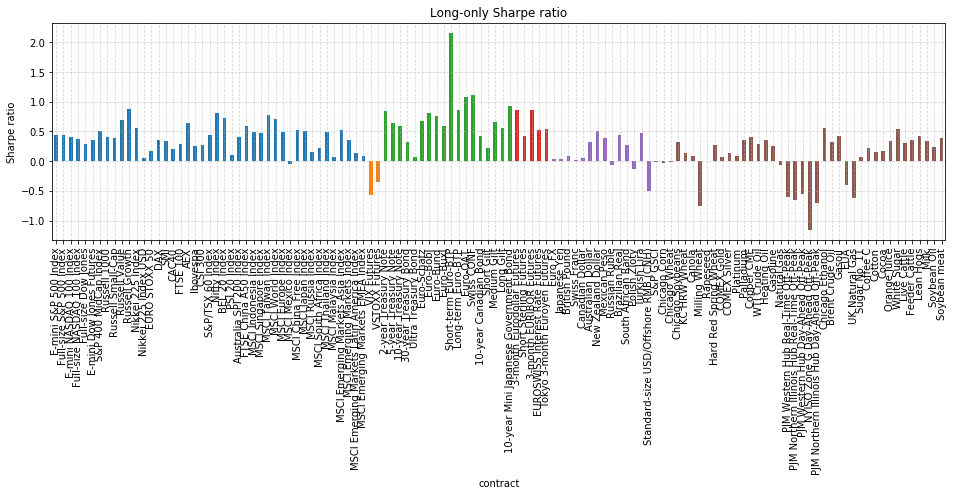

In [6]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.set_title("Long-only Sharpe ratio")
ax.set_ylabel("Sharpe ratio")
result_for_plot[PerfStats.SHARPE.value].plot(kind="bar", color=result_for_plot['color'], ax=ax, grid=True);

# Plot cumulative return series

Here only E-mini (concatenated with Full-size contract) futures is shown.

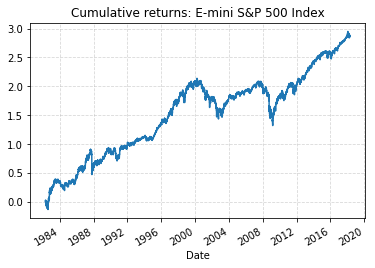

In [7]:
for fut in FuturesInfo:
    key, futures_info = fut.name, fut.value
    
    symbol = library.list_symbols(lo_ticker=key, nth_contract=1)  # only calculate 1st contract
    assert len(symbol) == 1
    item = library.read(symbol[0])
    data = item.data

    fig, ax = plt.subplots()
    data.get_final_net_returns().cumsum().plot(grid=True, ax=ax);
    ax.set_title('Cumulative returns: {}'.format(fut.value.full_name))

    break

# Trading volume

There are some contracts with zero daily trading volume. This is because either:
1. The contract no longer exists in the Quandl database (e.g., Full-size contract)
2. The trading volume is genuinely small (e.g., electricity futures)

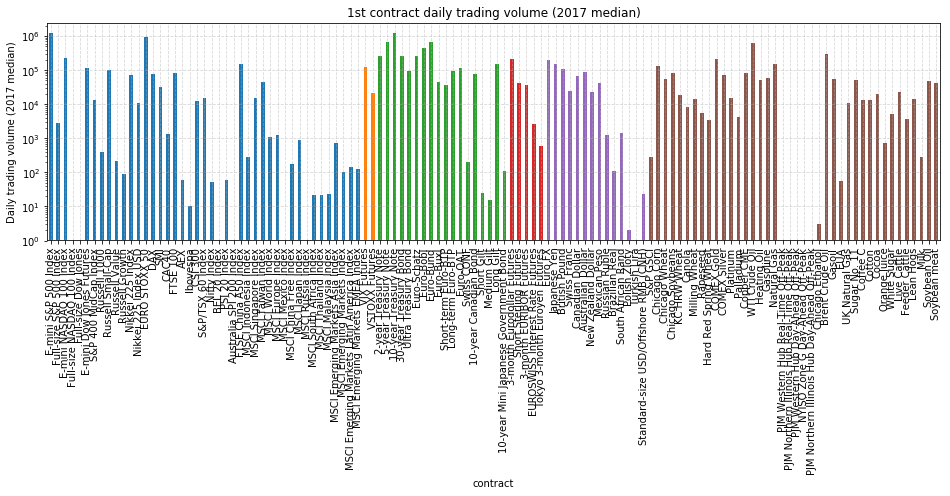

In [8]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.set_title("1st contract daily trading volume (2017 median)")
ax.set_ylabel("Daily trading volume (2017 median)")
result_for_plot['volume'].plot(kind="bar", color=result_for_plot['color'], ax=ax, grid=True, logy=True);